In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

file_path = '../../data/processed/feature_selected_data.parquet'
df = pd.read_parquet(file_path, engine= 'pyarrow')

In [3]:
# df.descrizione_attivita.value_counts()

In [4]:
# questo è un TODO definito nel file feature_selection.py ma ancora non fatto
df.drop(columns=['codice_struttura_erogazione'], inplace=True)
df['durata_erogazione_sec'] =  df.durata_erogazione_sec.astype(int)

In [5]:
df.columns

Index(['id_prenotazione', 'id_paziente', 'data_nascita', 'sesso',
       'regione_residenza', 'tipologia_servizio', 'descrizione_attivita',
       'data_contatto', 'tipologia_struttura_erogazione',
       'id_professionista_sanitario', 'tipologia_professionista_sanitario',
       'data_erogazione', 'durata_erogazione_sec', 'fascia_eta', 'anno',
       'quadrimestre'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460509 entries, 0 to 484290
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   id_prenotazione                     460509 non-null  object             
 1   id_paziente                         460509 non-null  object             
 2   data_nascita                        460509 non-null  datetime64[ns, UTC]
 3   sesso                               460509 non-null  object             
 4   regione_residenza                   460509 non-null  object             
 5   tipologia_servizio                  460509 non-null  object             
 6   descrizione_attivita                460509 non-null  object             
 7   data_contatto                       460509 non-null  object             
 8   tipologia_struttura_erogazione      460509 non-null  object             
 9   id_professionista_sanitario    

In [7]:
cols_grouped = ['anno', 'quadrimestre', 'regione_residenza', 'fascia_eta']

In [8]:
grouped = df.groupby(cols_grouped).size().reset_index(name='num_servizi')

In [9]:
grouped.sort_values(by=['num_servizi'], ascending=True)

,anno,quadrimestre,regione_residenza,fascia_eta,num_servizi
574,2019,4,Valle d'aosta,12-23,2
230,2019,2,Prov. auton. bolzano,0-11,2
252,2019,2,Sardegna,12-23,2
106,2019,1,Sardegna,12-23,2
1898,2022,1,Valle d'aosta,24-35,3
...,...,...,...,...,...
1070,2020,4,Lazio,0-11,1183
1232,2021,1,Lombardia,12-23,1321
1085,2020,4,Lombardia,12-23,1381
1231,2021,1,Lombardia,0-11,1486


In [10]:
df_cols_no_anno = cols_grouped.copy()
df_cols_no_anno.remove('anno')

In [11]:
# Calcolo dell'incremento per ogni quadrimestre
grouped['incremento'] = grouped.groupby(df_cols_no_anno)['num_servizi'].diff()


In [12]:
grouped.sort_values(by=['incremento'], ascending=False)

,anno,quadrimestre,regione_residenza,fascia_eta,num_servizi,incremento
1084,2020,4,Lombardia,0-11,1661,1308.0
1231,2021,1,Lombardia,0-11,1486,982.0
1085,2020,4,Lombardia,12-23,1381,981.0
1070,2020,4,Lazio,0-11,1183,935.0
1049,2020,4,Campania,0-11,1151,884.0
...,...,...,...,...,...,...
583,2019,4,Veneto,36-47,358,NaN
584,2019,4,Veneto,48-59,407,NaN
585,2019,4,Veneto,60-69,311,NaN
586,2019,4,Veneto,70+,420,NaN


In [13]:
# mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
# grouped[mask].sort_values(by=['anno'])

In [14]:
# DA NON FARE - Elimino i campioni con incremento nullo, sono quelli del 2019 (primo anno storicizzato)
# grouped = grouped.dropna(subset=['incremento'])

In [15]:

# Calcolo dell'incremento percentuale
grouped['incremento_percentuale'] = grouped['incremento'] / grouped.groupby(df_cols_no_anno)['num_servizi'].shift(1) * 100   # shift(1) per avere il valore precedente

# Calcolo dell'incremento percentuale medio per ogni coppia di quadrimestre e regione_erogazione
incremento_percentuale_medio = grouped.groupby(df_cols_no_anno)['incremento_percentuale'].mean().reset_index()

# Visualizza il risultato
app = incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)
app

,quadrimestre,regione_residenza,fascia_eta,incremento_percentuale
253,2,Sardegna,12-23,349.033816
546,4,Sardegna,0-11,330.667305
575,4,Valle d'aosta,12-23,311.688312
106,1,Sardegna,12-23,268.412698
231,2,Prov. auton. bolzano,0-11,249.128540
...,...,...,...,...
304,3,Basilicata,36-47,-11.524029
361,3,Marche,48-59,-13.121693
219,2,Molise,24-35,-13.930976
432,3,Valle d'aosta,60-69,-28.333333


In [16]:
# Visualizzo l'incremento percentuale anno in anno
# mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
# grouped[mask]

In [17]:
# Visualizzo, in un nuovo dataframe, l'incremento percentuale medio per ogni coppia di quadrimestre e regione_residenza
mask = (incremento_percentuale_medio['regione_residenza'] == 'Sicilia') & (incremento_percentuale_medio['quadrimestre'] == 4)
incremento_percentuale_medio[mask]

,quadrimestre,regione_residenza,fascia_eta,incremento_percentuale
553,4,Sicilia,0-11,107.235812
554,4,Sicilia,12-23,52.038340
555,4,Sicilia,24-35,0.250842
556,4,Sicilia,36-47,6.334314
557,4,Sicilia,48-59,4.025807
558,4,Sicilia,60-69,15.709449
559,4,Sicilia,70+,4.566925


Per studiare i dati e determinare le soglie appropriate per l'assegnazione delle etichette, puoi seguire alcuni passaggi che ti aiuteranno a comprendere meglio la distribuzione degli incrementi percentuali. Ecco una guida pratica su come fare:

1. Esplora la Distribuzione degli Incrementi Percentuali
Distribuzione: 
- Usa un istogramma o un grafico a densità per visualizzare la distribuzione degli incrementi percentuali.
- Statistica Descrittiva: Calcola metriche come la media, la mediana, i quartili, e la deviazione standard.

2. Identifica Valori Estremi (Outliers)
- Gli outlier possono influenzare significativamente le soglie. Identificare e, se necessario, trattare questi valori può essere utile.
- Puoi usare boxplot o interquartile range (IQR) per individuare gli outlier.

3. Segmentazione basata su Quartili
- I quartili (Q1, Q2, Q3) dividono i dati in quattro parti uguali. Usarli per definire le soglie può aiutarti a segmentare in modo equilibrato.

4. Visualizzazione dei Dati
- Scatter plot: Un grafico scatter può aiutare a vedere la relazione tra l'anno e l'incremento percentuale.
- Boxplot: Un boxplot mostra la distribuzione e può evidenziare outlier e valori medi.

In [18]:
# NB: forse i seguenti grafici sono inutili per il momento, ma li lascio per completezza

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


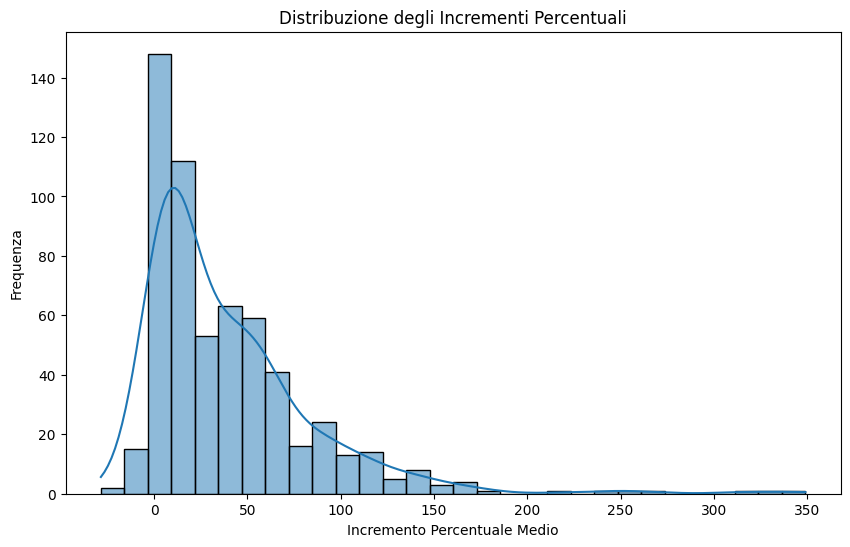

In [20]:
# Calcola la distribuzione degli incrementi percentuali
plt.figure(figsize=(10, 6))
sns.histplot(incremento_percentuale_medio['incremento_percentuale'], bins=30, kde=True)
plt.title('Distribuzione degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale Medio')
plt.ylabel('Frequenza')
plt.show()

In [21]:
# Statistiche descrittive
descr = incremento_percentuale_medio['incremento_percentuale'].describe()
print(descr)

count    588.000000
mean      39.792822
std       46.183586
min      -28.492063
25%        8.105028
50%       25.054381
75%       57.977008
max      349.033816
Name: incremento_percentuale, dtype: float64


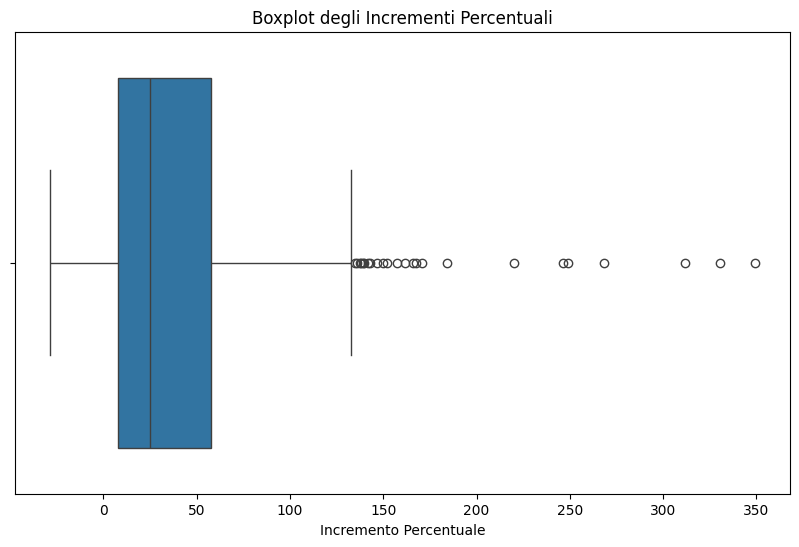

In [22]:
# Boxplot per identificare outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=incremento_percentuale_medio['incremento_percentuale'])
plt.title('Boxplot degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale')
plt.show()

In [23]:
# TODO: dobbiamo identificare anche il decremento?
    # IGNAZIO: si, ci possono essere degli incrementi percentuali medi negativi. Già verificato :(

def classify_increment(value):
    constat_increment = 5 
    low_increment = 15
    medium_increment = 40

    # TODO: fixare, bisogna mettere >= 0 nel primo if
    if value <= constat_increment and value >= 0:
        return 'constant_increment'
    elif value <= low_increment:
        return 'low_increment'
    elif value <= medium_increment:
        return 'medium_increment'
    elif value > medium_increment:
        return 'high_increment'
    else:
        return 'decrement'

In [24]:
incremento_percentuale_medio['incremento_teleassistenze'] = incremento_percentuale_medio['incremento_percentuale'].apply(classify_increment)

In [25]:
incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)

,quadrimestre,regione_residenza,fascia_eta,incremento_percentuale,incremento_teleassistenze
253,2,Sardegna,12-23,349.033816,high_increment
546,4,Sardegna,0-11,330.667305,high_increment
575,4,Valle d'aosta,12-23,311.688312,high_increment
106,1,Sardegna,12-23,268.412698,high_increment
231,2,Prov. auton. bolzano,0-11,249.128540,high_increment
...,...,...,...,...,...
304,3,Basilicata,36-47,-11.524029,low_increment
361,3,Marche,48-59,-13.121693,low_increment
219,2,Molise,24-35,-13.930976,low_increment
432,3,Valle d'aosta,60-69,-28.333333,low_increment


In [26]:
mask = (incremento_percentuale_medio['incremento_teleassistenze'] == 'high_increment')
incremento_percentuale_medio[mask]


,quadrimestre,regione_residenza,fascia_eta,incremento_percentuale,incremento_teleassistenze
0,1,Abruzzo,0-11,139.410774,high_increment
1,1,Abruzzo,12-23,117.323481,high_increment
2,1,Abruzzo,24-35,87.535476,high_increment
3,1,Abruzzo,36-47,53.217938,high_increment
5,1,Abruzzo,60-69,58.864268,high_increment
...,...,...,...,...,...
574,4,Valle d'aosta,0-11,108.429487,high_increment
575,4,Valle d'aosta,12-23,311.688312,high_increment
577,4,Valle d'aosta,36-47,51.342593,high_increment
581,4,Veneto,0-11,112.835651,high_increment


In [27]:
# df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[(incremento_percentuale_medio['regione_erogazione'] == x['regione_erogazione']) & (incremento_percentuale_medio['quadrimestre'] == x['quadrimestre'])]['incremento_teleassistenze'].values[0], axis=1)


# Qui vado a mappare il valore di incremento_teleassistenze nel dataframe principale (ci mette un po ad eseguirsi)


#df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[
#    (incremento_percentuale_medio[df_cols_no_anno] == x[df_cols_no_anno].values).all(axis=1)
#]['incremento_teleassistenze'].values[0], axis=1)


In [28]:
df = df.merge(incremento_percentuale_medio[df_cols_no_anno + ['incremento_teleassistenze']], 
              on=df_cols_no_anno, 
              how='left')

In [29]:
df.incremento_teleassistenze.value_counts()

incremento_teleassistenze
high_increment        169056
low_increment         158135
medium_increment       72158
constant_increment     61160
Name: count, dtype: int64

In [30]:
df.to_parquet('../../data/processed/ds_labeled.parquet')


## CONTINUA NEL NOTEBOOK "importanza_feature_uff (non necessario per ora)

In [31]:
# mask = (df.regione_residenza == 'Lazio') & (df.sesso == 'male') & (df.tipologia_struttura_erogazione == 'Fondazione IRCCS') & (df.quadrimestre == 1)
# df[mask]

In [32]:
# mask = (df.regione_residenza == 'Abruzzo') & (df.sesso == 'female') & (df.tipologia_struttura_erogazione == 'Ospedale a gestione diretta') & (df.quadrimestre == 1)
# up = df[mask]

In [33]:
# up.incremento_teleassistenze.value_counts()